In [1]:
%run ./utils/jupyter_configs/loadcell.py
%run ./utils/jupyter_configs/imagestyling.py

Ip 7/11/2025
FORMAT OF PROJECT FILE.(hardcopy)
1.Title page(designed by you)
2.Certificate(school will give)
3.Acknowledgement
4.Output of the Project
5.Source code
6.csv files used
7.bibliography.
Thank you
# Spotify Data Analysis

## Downloading your own account's listening history
- Go to your [Spotify Account page](https://www.spotify.com/in-en/account/privacy/), and under `Download your data` section check `Select Extended streaming history` and request data.

- Spotify would then send you a confirmation mail, click confirm and wait for the data to get compiled.

## Generating your own Analysis

1. Clone this repo or download the zip and extract it to a folder

 
```bash
git clone https://github.com/d1vij/spotify-data-analysis/
```

2. If on unix based environments, run `setup.sh`
```bash
bash setup.sh
```
Else manually create a venv and install `requirements.txt`

3. Start the jupyter server
```bash
jupyter lab
```
4. Open and run all cells of this notebook (_project.ipynb_)

# About the project

The project involves analysis all the tracks listened on Spotify. (Think of it like a mini Spotify wrapped :))

This project majorly uses pandas for data manipulation and matplotlib and along with seaborn for all the plottings along with a bit of external libraries here and there.

All the helper functions and utilites is made into a unified module `utils` and further description along with its working is explained in each of its corresponding submodules.

All generic plots are present in `utils.plot_sources.plotters` module whereas the functions utilizing them to generate analysis ae present in the `utils.plot_sources.analysis_plots` module


# Imports and configurations

In [2]:
from os import path
import pandas as pd

# Prevent wrapping of dataframes when printed
pd.set_option("display.expand_frame_repr", False)


# Disabling warnings generated by matplotlib
import warnings

warnings.filterwarnings("ignore")


from utils.generate_frame import generate_frame

# Plot imports
from utils.plot_sources.analysis_plots.top_n import top_analysis
from utils.plot_sources.analysis_plots.daily_tracks_graph import daily_tracks_graph
from utils.plot_sources.analysis_plots.daily_listening_activity import (
    daily_listening_activity,
)
from utils.plot_sources.analysis_plots.track_playtime_kde_dist import (
    track_playtime_kde_dist,
)
from utils.plot_sources.analysis_plots.per_artist_analysis import (
    interactive_per_artist_analysis,
)
from utils.plot_sources.analysis_plots.artist_corelation_plot import (
    artist_correlation_plot,
)

## About the data
Spotify provides a zip file containing all of listening history split into json files of a max size of around 12KB

![Manual Unzipping](https://github.com/d1vij/spotify-data-analysis/blob/main/images/manual_unzipping.png?raw=true)

Although this could've been unzipped and processed manually, the script `utils.process_zip` does it automatically for us :P.

The data compilation and dataframe creation steps are as follows
### 1. Asking the user path where the zip file is stored
### 2. Unzipping it, and reading every json file having the name prefix *Streaming_History_Audio_*

Each json file is an array of objects like

```json
{
    "ts": "2023-04-09T14:24:49Z",
    "platform": "android",
    "ms_played": 185733,
    "conn_country": "IN",
    "ip_addr": "152.57.221.62",
    "master_metadata_track_name": "Here Comes The Sun - Remastered 2009",
    "master_metadata_album_artist_name": "The Beatles",
    "master_metadata_album_album_name": "Abbey Road",
    "spotify_track_uri": "spotify:track:6dGnYIeXmHdcikdzNNDMm2",
    "episode_name": null,
    "episode_show_name": null,
    "spotify_episode_uri": null,
    "audiobook_title": null,
    "audiobook_uri": null,
    "audiobook_chapter_uri": null,
    "audiobook_chapter_title": null,
    "reason_start": "playbtn",
    "reason_end": "trackdone",
    "shuffle": false,
    "skipped": false,
    "offline": false,
    "offline_timestamp": 1681050047,
    "incognito_mode": false
}
```
On analyzing all the objects, I compiled all the possible attributes and the values a track info object could have

```py
class TrackInfo(TypedDict, total=True):
    """
    Class describing each data object in spotify's listening history json file
    """

    ts: str
    platform: str
    ms_played: int
    conn_country: str
    ip_addr: str
    master_metadata_track_name: str
    master_metadata_album_artist_name: str
    master_metadata_album_album_name: str
    spotify_track_uri: str
    episode_name: Optional[str]
    episode_show_name: Optional[str]
    spotify_episode_uri: Optional[str]
    audiobook_title: Optional[str]
    audiobook_uri: Optional[str]
    audiobook_chapter_uri: Optional[str]
    audiobook_chapter_title: Optional[str]
    reason_start: Optional[
        Literal[
            "playbtn",
            "fwdbtn",
            "backbtn",
            "trackdone",
            "clickrow",
            "appload",
            "remote",
            "trackerror",
            "unknown",
        ]
    ]
    reason_end: Optional[
        Literal[
            "fwdbtn",
            "backbtn",
            "logout",
            "endplay",
            "trackdone",
            "unknown",
            "remote",
            "unexpected-exit-while-paused",
            "unexpected-exit",
            "trackerror",
        ]
    ]
    shuffle: bool
    skipped: bool
    offline: bool
    offline_timestamp: int
    incognito_mode: bool
```

### 3. Filtering out only the required data from the whole

Although spotify provides alot of metrics, (see `utils.TrackInfoClasses.SongAttributes`), the metrics i have used are

1. `ts` -> Timestamp at which the track was listened
2. `ms_played` -> Total ms the track was played
3. `master_metadata_track_name` -> Track name
4. `master_metadata_album_artist_name` -> Primary Artist name
5. `master_metadata_album_album_name` -> Album name

The final compiled JSON file is a large (around 11MB for my data) file containing array of `utils.TrackInfoClasses.FilteredTrackInfo` objects similar to
```json
{
    "ts": "2025-07-10T17:31:04Z",
    "ms_played": 255080,
    "master_metadata_track_name": "In Bloom",
    "master_metadata_album_artist_name": "Nirvana",
    "master_metadata_album_album_name": "Nevermind"
}
```

In [3]:
print("Dataframe containing track info")
df = generate_frame("./data/my_spotify_data.zip")
print(df.head(20))

print("Dataframe containing artist info")
artists_df = pd.read_csv(path.abspath("./ext_data/global_music_artists.csv"))
print(artists_df.head(20))

Dataframe containing track info
                          ts  ms_played              master_metadata_track_name master_metadata_album_artist_name master_metadata_album_album_name
0  2021-08-11 09:22:28+00:00          0                         Loveeeeeee Song                           Rihanna            Unapologetic - Deluxe
1  2021-08-11 09:26:45+00:00     256186                         Loveeeeeee Song                           Rihanna            Unapologetic - Deluxe
2  2021-08-11 09:26:45+00:00     256186                         Loveeeeeee Song                           Rihanna            Unapologetic - Deluxe
3  2021-08-11 09:30:32+00:00     226955                                 Streets                          Doja Cat                         Hot Pink
4  2021-08-11 09:34:15+00:00     222437                          Feel Good Inc.                          Gorillaz                       Demon Days
5  2021-08-11 09:37:40+00:00     204452                                Mask Off       

## All the analysis

### Top analysis

Analyzing the top artists, tracks, albums and genres the user has been listening to


Out of 1113 artists, the top 50 artists based on track playtimes (in hours) are
1. Gorillaz - 10.4            2. Beyoncé - 9.5
3. Childish Gambino - 8.2     4. Doja Cat - 8.1
5. Lana Del Rey - 7.5         6. The Weeknd - 6.3
7. Kanye West - 5.6           8. Rihanna - 5.3
9. Michael Jackson - 4.9      10. Mitraz - 4.4
11. Kendrick Lamar - 4.4      12. BTS - 4.2
13. Travis Scott - 4.1        14. Erykah Badu - 3.9
15. Drake - 3.7               16. Måneskin - 3.6
17. Post Malone - 3.4         18. RM - 3.1
19. Pritam - 3.1              20. Tyler, The Creator - 2.9
21. ¥$ - 2.8                  22. Atif Aslam - 2.4
23. System Of A Down - 2.4    24. Future - 2.3
25. Thaikkudam Bridge - 2.3   26. HIM - 2.2
27. Mareux - 2.2              28. Rammstein - 2.1
29. Lady Gaga - 2.0           30. JEY - 2.0
31. Outkast - 1.9             32. Labrinth - 1.9
33. J. Cole - 1.8             34. JAY-Z - 1.8
35. Agust D - 1.8             36. Frank Ocean - 1.8
37. Ayushmann Khurrana - 1.7  38. Vishal-Shekhar - 

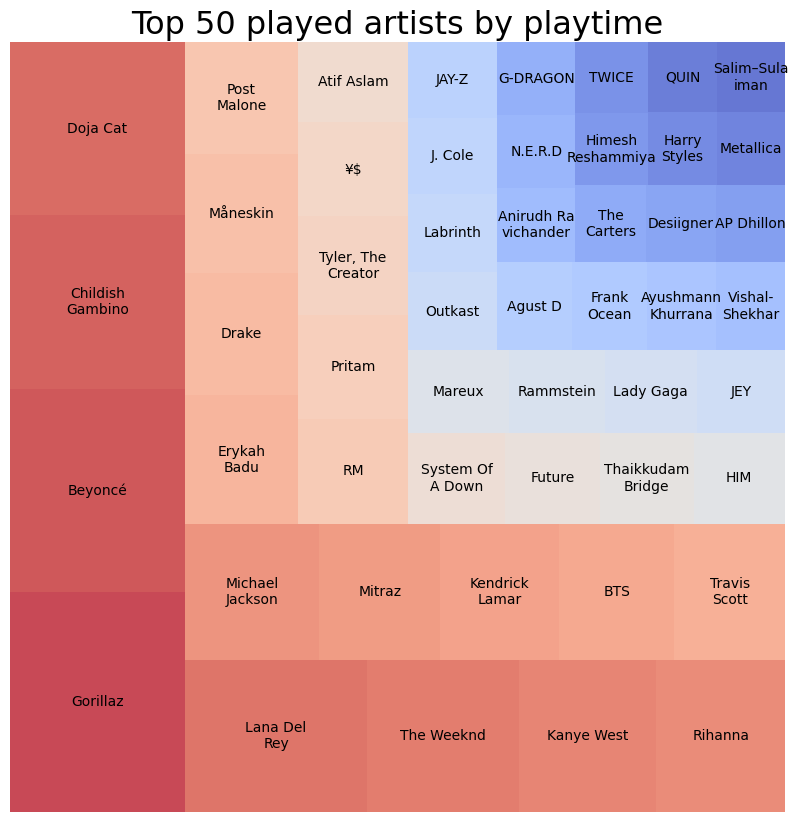

Out of 3196 unique tracks, the top 50 played tracks are
1. Loveeeeeee Song - 55                           2. Streets - 44
3. ZITTI E BUONI - 39                             4. APESHIT - 32
5. Lemon - 32                                     6. Panda - 27
7. GO HARD - 26                                   8. LOYALTY. FEAT. RIHANNA. - 26
9. Mushroom Chocolate (with 6LACK) - 25           10. Feel Good Inc. - 25
11. La Câlin - 23                                 12. Mask Off - 23
13. Pani Da Rang Male (From "Vicky Donor") - 23   14. Flawless Remix (feat. Nicki Minaj) - 20
15. Formation - 19                                16. Man Down - 19
17. Dick (feat. Doja Cat) - 18                    18. Get You The Moon (feat. Snøw) - 17
19. Vibe - 16                                     20. Streets - Silhouette Remix - 16
21. Aathma Raama - 16                             22. Youngblood - 15
23. MONEY - 15                                    24. I WANNA BE YOUR SLAVE - 15
25. Navarasam - 14                  

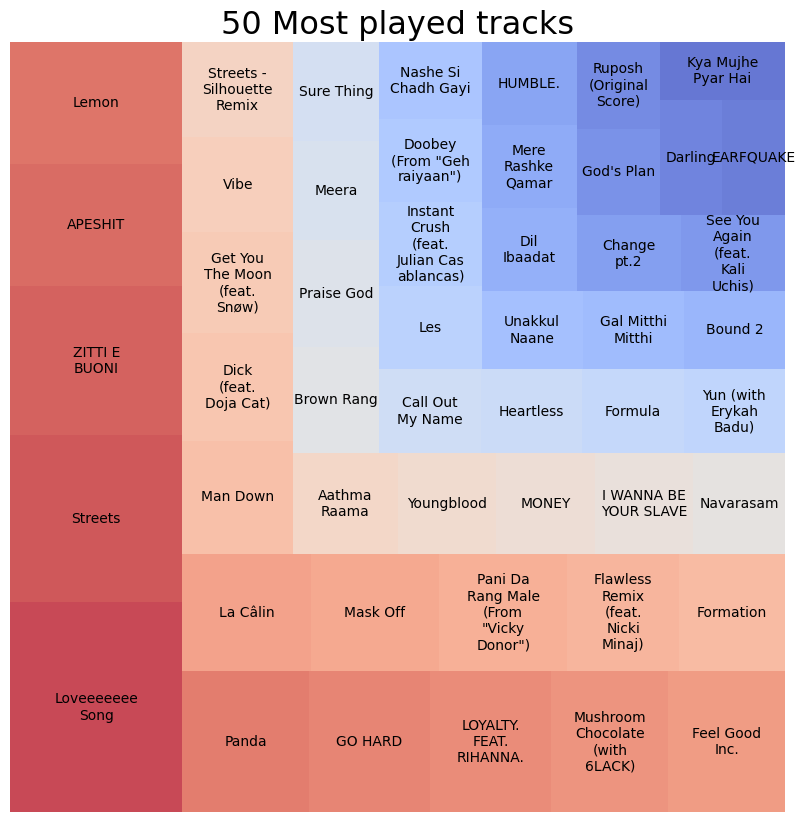

Out of 2178 unique albums, the top 50 played albums based on approximate playcounts are
1. EVERYTHING IS LOVE - 32                                         2. NO ONE EVER REALLY DIES - 32
3. Panda - 27                                                      4. LUCID - 25
5. Vicky Donor - 23                                                6. La Câlin - 23
7. FUTURE - 23                                                     8. Unapologetic - Deluxe - 21
9. Teatro d'ira - Vol. I - 19                                      10. Dick (feat. Doja Cat) - 18
11. Get You The Moon (feat. Snøw) - 17                             12. Hot Pink - 17
13. Aathma Raama - 16                                              14. Eyes Wide Open - 15
15. Youngblood - Deluxe - 14                                       16. Donda - 14
17. DAMN. - 13                                                     18. Doobey - 13
19. The Come Up - 13                                               20. MoonChild Era - 12
21. Befikre - 12      

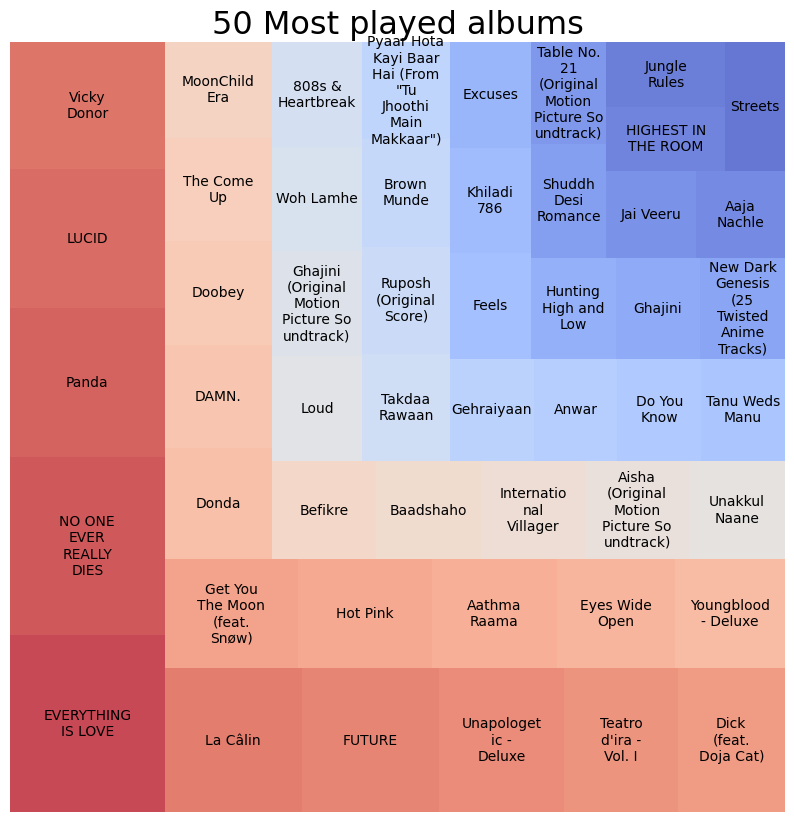

Where the artists you listened to come from
Out of 40 countries, most of the artists you listen to are from United States with a total of 308 artists!!

Top 10 countries by artist count are:
1. United States - 308 2. United Kingdom - 106
3. India - 63          4. France - 23
5. South Korea - 23    6. Germany - 22
7. Japan - 19          8. Canada - 17
9. Australia - 14      10. Sweden - 13

What genres do you listen to
Out of 605 genres, you listen to pop the most with a total of 98 artists under that genre!!

Top 20 genres by artist count are:
1. pop - 98               2. filmi - 73
3. rock - 65              4. rap - 64
5. hip hop - 58           6. dance pop - 48
7. modern bollywood - 45  8. r&b - 41
9. pop rap - 35           10. k-pop - 31
11. modern rock - 28      12. urban contemporary - 27
13. trap - 26             14. permanent wave - 22
15. hard rock - 22        16. classic rock - 22
17. album rock - 20       18. soft rock - 20
19. alternative rock - 19 20. neo soul - 18


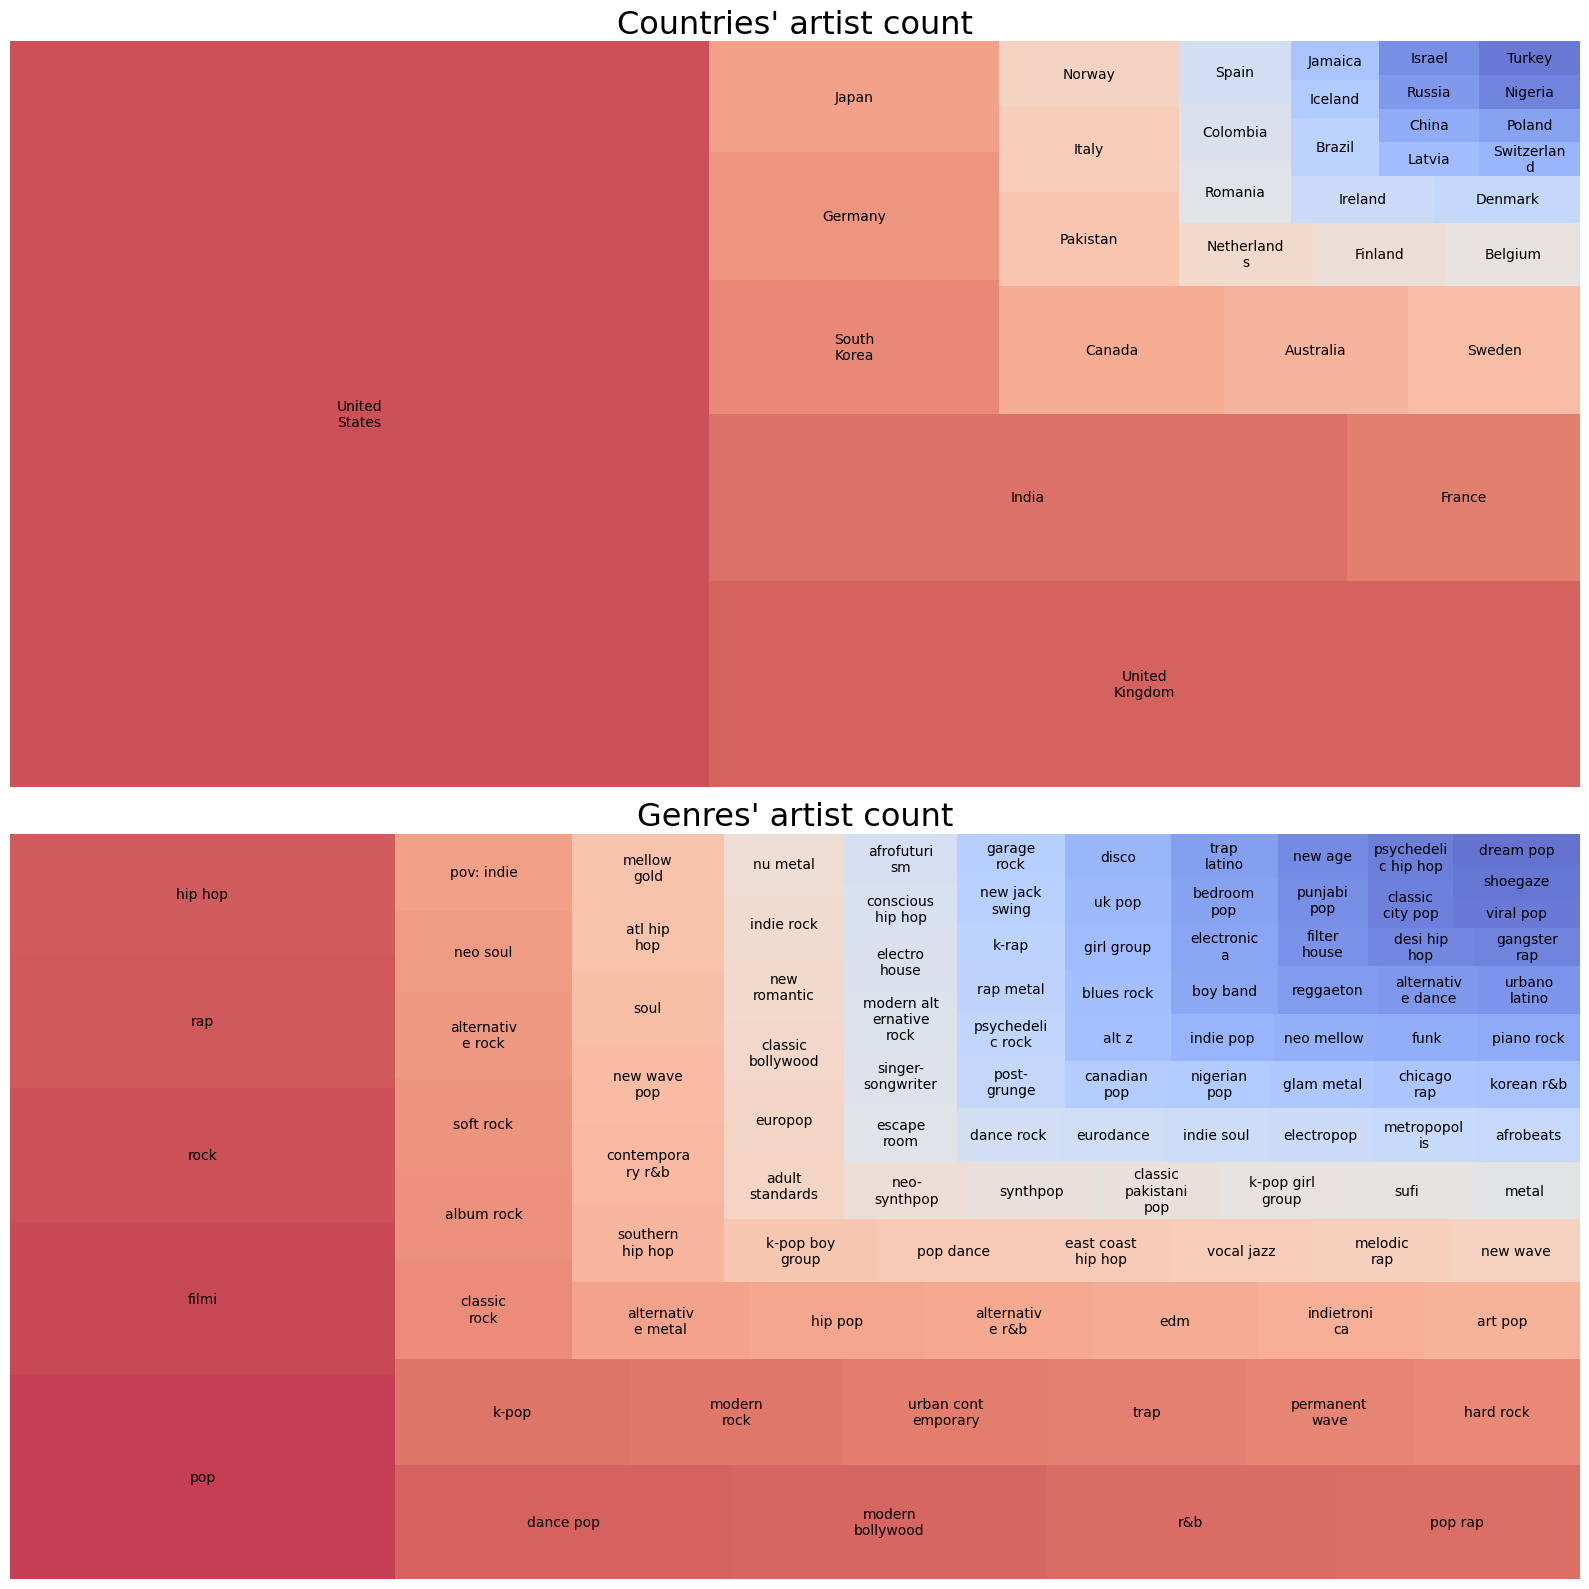

In [4]:
top_analysis(df, artists_df)

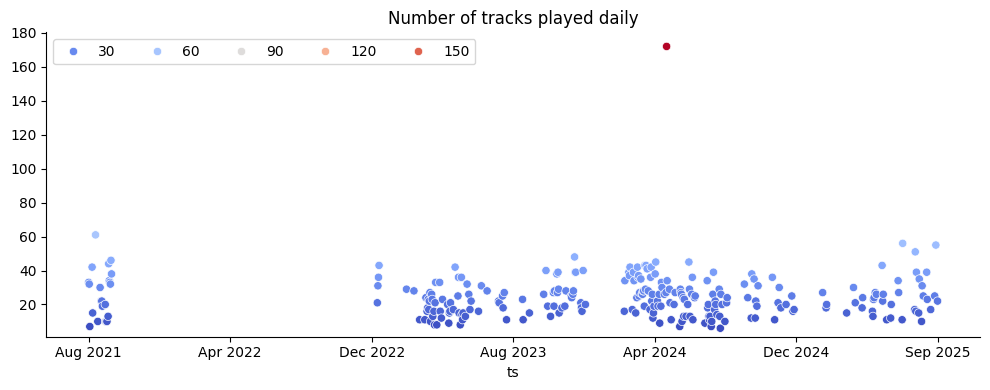

In [5]:
daily_tracks_graph(df)

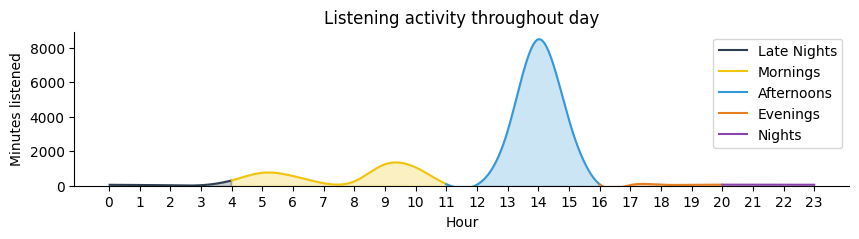

In [6]:
# Line plot
daily_listening_activity(df)

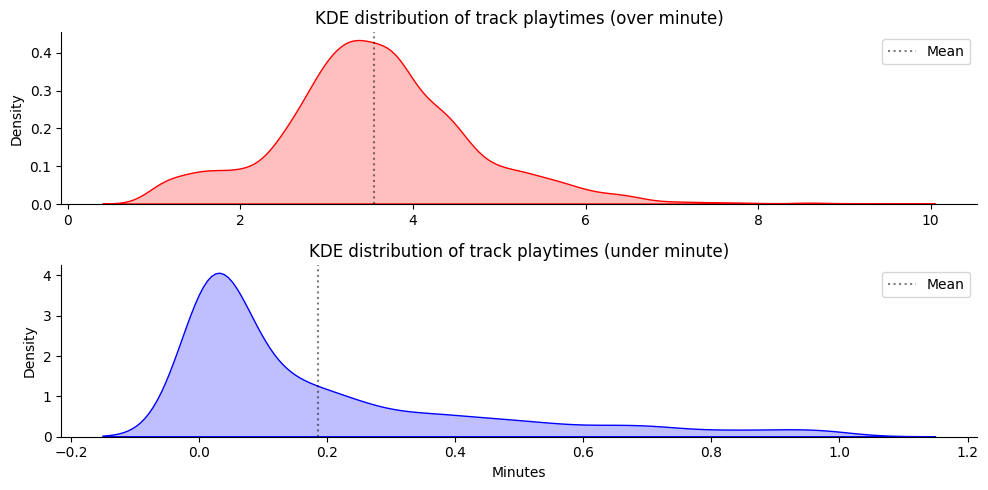

In [7]:
# Line plot
track_playtime_kde_dist(df)

In [ ]:
interactive_per_artist_analysis(df, artists_df)

What do you want to do ??
(1) Display top artist analysis for top artists
(2) Display analysis for custom artist
(*) Exit
 2
Input the name of the artist:  Frank


Input the name of the artist: Frank
['Rihanna' 'Rihanna' 'Rihanna' ... 'Indian Ocean' 'Thaikkudam Bridge'
 'Dhanda Nyoliwala']
Found 9 matches, select the number for which one to choose
1. Frank Sinatra   2. Frank Ocean
3. FrankJavCee     4. Aretha Franklin
5. Franz Ferdinand 6. Franz Gordon
7. Imran Khan      8. Simiran Kaur Dhadli


Artist index:  0
Artist index:  0
Artist index:  0


In [ ]:
artist_correlation_plot(df)

## Exporting to html

This jupyter notebook is converted into a ready to print html saved at /build/project.html

In [ ]:
%run ./scripts/export.py

## Source code

All source files required for this project compiled into one single cell. Does not include any of the external data.

Source code best viewed directly on the repo.

In [ ]:
%%capture
# ^ Catches all the output of this cell

# Run the script to compile all python files
%run ./scripts/bake.py

# Paste the content of the compiled file into this cell
%loadnext ./builds/built.pie

# This raises error but also prevents running this cell :)
raise SystemError


###### /home/divij/coding/projects/spotify-data-analysis/utils/smoothen.py #####


from scipy.interpolate import make_interp_spline
import pandas as pd
import numpy as np


# Smoothens a series by applying spline function over it
# More the amount, more smoother the curve would be
# and more time it would take to generate the interpolation
def smoothen(ser: pd.Series, amount: int):
    if amount > 1e5:
        raise RuntimeError("Reconsider the amount since it might cause large runtimes")  # lmao
    spline = make_interp_spline(ser.index, ser.values)
    x_points = np.linspace(ser.index.min(), ser.index.max(), amount, endpoint=True)
    y_points = spline(x_points)
    return pd.Series(y_points, index=x_points)


# /home/divij/coding/projects/spotify-data-analysis/utils/jupyter_configs/imagestyling.py


from IPython.core.display import HTML

HTML("""
<style>
    div.output_area img, div.output_area svg {
        max-width: 100% !important;
        height: auto !important;
    }
</style>
""")


# /home/divij/coding/projects/spotify-data-analysis/utils/jupyter_configs/loadcell.py


from IPython.core.magic import Magics, magics_class, line_magic
from pathlib import Path
from IPython import get_ipython


@magics_class
class LoadNextMagics(Magics):
    @line_magic
    def loadnext(self, path):
        path = path.strip()
        text = Path(path).read_text(encoding="utf8")

        # Insert the file's content into the NEXT cell
        ip = get_ipython()
        ip.set_next_input(text, replace=True)

        return


ip = get_ipython()
ip.register_magics(LoadNextMagics)


#### /home/divij/coding/projects/spotify-data-analysis/utils/process_zip.py ####


import os
from os import path
import shutil
import zipfile

import json
import pandas as pd

from utils.TrackInfoClasses import *


def read_file(name: str) -> SongInfoArray:
    with open(name, "r", encoding="utf-8") as file:
        return json.load(file)


def extract_filtered(song_info_obj, filters: list[SongAttributes]) -> FilteredTrackInfo:
    filtered = {}
    for filter in filters:
        filtered[filter] = song_info_obj[filter]
    return cast(FilteredTrackInfo, filtered)


# Unzips the spotify data zip file and compiles all the Audio Listening History files into one singular json.
# Returns the path of the compiled json file
def process_zip(filepath: str, filters: list[SongAttributes]):
    filename = path.basename(filepath).split(".")[0]
    # print(f"Filename {filename}")

    zip_extract_path = path.join(
        path.dirname(filepath),
        filename,  # directory name same as filename
    )

    # print(f"{zip_extract_path=}")
    out_json_path = path.join(path.dirname(filepath), filename + ".json")

    with zipfile.ZipFile(filepath) as __zipfile:
        __zipfile.extractall(path=zip_extract_path)

    if "Spotify Extended Streaming History" not in os.listdir(zip_extract_path):
        raise TypeError(
            "Zip file is not spotify data, it must contain a folder named 'Spotify Extended Streaming History'"
        )

    data_folder = path.join(zip_extract_path, "Spotify Extended Streaming History")

    if path.exists(data_folder) is False:
        raise RuntimeError(f"Cannot path for {data_folder=}")

    files = [
        os.path.join(data_folder, file)
        for file in os.listdir(data_folder)
        if file.startswith("Streaming_History_Audio")  # only including the Audio History files
    ]

    songs = [song for file in files for song in read_file(file)]
    filtered = [extract_filtered(song, filters) for song in songs]
    tracks = pd.DataFrame(filtered)

    tracks.to_json(out_json_path, date_format="iso", orient="records")

    # cleanup
    # os.remove(filepath)
    shutil.rmtree(zip_extract_path)
    return out_json_path


# /home/divij/coding/projects/spotify-data-analysis/utils/series_textellipses.py


from pandas import Series


# Clips and appends ellipses (...) for string values in series greater than characters
def index_ellipses(ser: Series, characters: int):
    indexes = list(ser.index.copy(deep=True))

    for idx in range(len(indexes)):
        if len(indexes[idx]) > characters:
            indexes[idx] = indexes[idx][:characters] + "..."

    ser.index = indexes


## /home/divij/coding/projects/spotify-data-analysis/utils/TrackInfoClasses.py #


from typing import TypedDict, Literal, Optional, cast


class TrackInfo(TypedDict, total=True):
    ts: str
    platform: str
    ms_played: int
    conn_country: str
    ip_addr: str
    master_metadata_track_name: str
    master_metadata_album_artist_name: str
    master_metadata_album_album_name: str
    spotify_track_uri: str
    episode_name: Optional[str]
    episode_show_name: Optional[str]
    spotify_episode_uri: Optional[str]
    audiobook_title: Optional[str]
    audiobook_uri: Optional[str]
    audiobook_chapter_uri: Optional[str]
    audiobook_chapter_title: Optional[str]
    reason_start: Optional[
        Literal[
            "playbtn",
            "fwdbtn",
            "backbtn",
            "trackdone",
            "clickrow",
            "appload",
            "remote",
            "trackerror",
            "unknown",
        ]
    ]
    reason_end: Optional[
        Literal[
            "fwdbtn",
            "backbtn",
            "logout",
            "endplay",
            "trackdone",
            "unknown",
            "remote",
            "unexpected-exit-while-paused",
            "unexpected-exit",
            "trackerror",
        ]
    ]
    shuffle: bool
    skipped: bool
    offline: bool
    offline_timestamp: int
    incognito_mode: bool


class FilteredTrackInfo(TypedDict):
    ts: Optional[str]
    platform: Optional[str]
    ms_played: Optional[int]
    conn_country: Optional[str]
    ip_addr: Optional[str]
    master_metadata_track_name: Optional[str]
    master_metadata_album_artist_name: Optional[str]
    master_metadata_album_album_name: Optional[str]
    spotify_track_uri: Optional[str]
    episode_name: Optional[str]
    episode_show_name: Optional[str]
    spotify_episode_uri: Optional[str]
    audiobook_title: Optional[str]
    audiobook_uri: Optional[str]
    audiobook_chapter_uri: Optional[str]
    audiobook_chapter_title: Optional[str]
    reason_start: Optional[
        Literal[
            "playbtn",
            "fwdbtn",
            "backbtn",
            "trackdone",
            "clickrow",
            "appload",
            "remote",
            "trackerror",
            "unknown",
        ]
    ]
    reason_end: Optional[
        Literal[
            "fwdbtn",
            "backbtn",
            "logout",
            "endplay",
            "trackdone",
            "unknown",
            "remote",
            "unexpected-exit-while-paused",
            "unexpected-exit",
            "trackerror",
        ]
    ]
    shuffle: Optional[bool]
    skipped: Optional[bool]
    offline: Optional[bool]
    offline_timestamp: Optional[int]
    incognito_mode: Optional[bool]


SongInfoArray = list[TrackInfo]
FilteredSongInfoArray = list[FilteredTrackInfo]
SongAttributes = Literal[
    "ts",
    "platform",
    "ms_played",
    "conn_country",
    "ip_addr",
    "master_metadata_track_name",
    "master_metadata_album_artist_name",
    "master_metadata_album_album_name",
    "spotify_track_uri",
    "episode_name",
    "episode_show_name",
    "spotify_episode_uri",
    "audiobook_title",
    "audiobook_uri",
    "audiobook_chapter_uri",
    "audiobook_chapter_title",
    "reason_start",
    "reason_end",
    "shuffle",
    "skipped",
    "offline",
    "offline_timestamp",
    "incognito_mode",
]


## /home/divij/coding/projects/spotify-data-analysis/utils/series_textwrap.py ##


import textwrap
from pandas import Series


# Wraps the series indexes to width number of characters
def index_wrap(ser: Series, width: int):
    # Series passed as reference
    ser.index = [textwrap.fill(l, width=width) for l in ser.index.values]  # type: ignore


def list_wrap(l: list, width: int):
    # Series passed as reference
    return list(textwrap.fill(t, width=width) for t in l)


## /home/divij/coding/projects/spotify-data-analysis/utils/fuzzy_searchers.py ##


# Fuzzy searching artists / track name
from rapidfuzz import fuzz
import pandas as pd
from typing import Literal


# Fuzzy searcher searches for given word in a series, dataframe, or list of strings
# and return the closest matches sorted in descending order of confidence
# For searching within single worded sequences prefer partial ratio (example for artist names)
# and for multi word sequences prefer token set ratio (example Track names)
def fuzzy_search(
    phrase: str,
    sequence: pd.DataFrame | pd.Series | list[str],
    _search_type: Literal["partial ratio", "token set ratio"],
    *,
    confidence: int = 80,
    col_name: str | None = None,
    top_n=5,  # If negative, returns matched words
):
    search_type = 0 if (_search_type == "partial ratio") else 1

    if type(sequence) is pd.DataFrame:
        if col_name is None:
            raise ValueError("Must provide a columnn name to fuzzy search when sequence is a DataFrame")
        data = sequence[col_name].values

    elif type(sequence) is pd.Series:
        if col_name is not None:
            raise ValueError("Cannot provide a col_name if sequence is of type Series")
        data = sequence.values

    elif isinstance(sequence, list):
        data = sequence

    else:
        raise (TypeError(f"Type of sequence must be pd.Series, pd.Dataframe or list[str] and not {type(sequence)}"))

    if not isinstance(sequence[0], str):
        raise (TypeError("Values of sequence can only be of type string"))

    matched = []
    ratios = []
    for value in data:
        if value is not None:
            if search_type == 0:
                ratio = fuzz.partial_ratio(phrase.lower(), value.lower())
            else:
                ratio = fuzz.token_set_ratio(phrase.lower(), value.lower())

            if (ratio >= confidence) and (value not in matched):
                matched.append(value)
                ratios.append(ratio)

    artists = [
        value
        for value, _ in sorted(
            [(value, ratio) for value, ratio in zip(matched, ratios)],
            key=lambda p: p[1],
            reverse=True,
        )
    ]
    if top_n < 0:
        return artists
    else:
        return artists[:top_n]


### /home/divij/coding/projects/spotify-data-analysis/utils/generate_frame.py ##


from os.path import isfile, abspath
import pandas as pd

from utils.process_zip import SongAttributes
from utils.process_zip import process_zip

DEBUG = True


# Asks user for the filepath of the spotify data zip file
# and processes it into a cleaned up dataframe
def generate_frame():
    try:
        while True:
            if DEBUG:
                raise RuntimeError
            zip_path = abspath(input("Path of zip file?? : "))
            if isfile(zip_path):
                break
    except:
        # Runtime doesnt support raw inputs
        zip_path = abspath("./data/my_spotify_data.zip")

    filters: list[SongAttributes] = [
        "ts",
        "ms_played",
        "master_metadata_track_name",
        "master_metadata_album_artist_name",
        "master_metadata_album_album_name",
    ]

    compiled_json_path = process_zip(zip_path, filters)
    df = pd.read_json(compiled_json_path)

    # Converting the ts column to datetime object
    df["ts"] = pd.to_datetime(df["ts"])
    return df


# /home/divij/coding/projects/spotify-data-analysis/utils/data_cleaning/clean_global_music_artists.py


import pandas as pd
from os import path

# Original CSV
# https://www.kaggle.com/datasets/harshdprajapati/worldwide-music-artists-dataset-with-image

csv_path = path.abspath(path.join(__file__, "../../../ext_data/global_music_artists.csv"))
# Only reading the required columns from the csv
df = pd.read_csv(csv_path, usecols=["artist_name", "artist_genre", "country"])

# Overwriting the original
df.to_csv(csv_path, index=False)


###### /home/divij/coding/projects/spotify-data-analysis/utils/printers.py #####


import chalk


class Printer:
    """Utility class for printing styled terminal output using pychalk."""

    @staticmethod
    def _join(*args):
        return " ".join(map(str, args))

    @staticmethod
    def red(*args):
        print(chalk.red(Printer._join(*args)))

    @staticmethod
    def green(*args):
        print(chalk.green(Printer._join(*args)))

    @staticmethod
    def yellow(*args):
        print(chalk.yellow(Printer._join(*args)))

    @staticmethod
    def blue(*args):
        print(chalk.blue(Printer._join(*args)))

    @staticmethod
    def magenta(*args):
        print(chalk.magenta(Printer._join(*args)))

    @staticmethod
    def cyan(*args):
        print(chalk.cyan(Printer._join(*args)))

    @staticmethod
    def white(*args):
        print(chalk.white(Printer._join(*args)))

    @staticmethod
    def red_bold(*args):
        print(chalk.bold(chalk.red(Printer._join(*args))))

    @staticmethod
    def green_bold(*args):
        print(chalk.bold(chalk.green(Printer._join(*args))))

    @staticmethod
    def yellow_bold(*args):
        print(chalk.bold(chalk.yellow(Printer._join(*args))))

    @staticmethod
    def blue_bold(*args):
        print(chalk.bold(chalk.blue(Printer._join(*args))))

    @staticmethod
    def red_underline(*args):
        print(chalk.underline(chalk.red(Printer._join(*args))))

    @staticmethod
    def green_underline(*args):
        print(chalk.underline(chalk.green(Printer._join(*args))))

    @staticmethod
    def yellow_underline(*args):
        print(chalk.underline(chalk.yellow(Printer._join(*args))))

    @staticmethod
    def blue_underline(*args):
        print(chalk.underline(chalk.blue(Printer._join(*args))))

    @staticmethod
    def cyan_underline(*args):
        print(chalk.underline(chalk.cyan(Printer._join(*args))))

    @staticmethod
    def magenta_underline(*args):
        print(chalk.underline(chalk.magenta(Printer._join(*args))))


###### /home/divij/coding/projects/spotify-data-analysis/utils/filters.py ######


import pandas as pd

df_or_series = pd.DataFrame | pd.Series


# Filters to filter row data based on values
class Filters:
    @staticmethod
    def rows_gt(value: int | float, obj: df_or_series):
        if type(obj) is pd.Series:
            return obj[obj > value]
        elif type(obj) is pd.DataFrame:
            return obj[(obj > value).all(axis=1)]
        else:
            raise TypeError("Can filter only Series or DataFrame objects")

    @staticmethod
    def rows_lt(value: int | float, obj: df_or_series):
        if type(obj) is pd.Series:
            return obj[obj < value]
        elif type(obj) is pd.DataFrame:
            return obj[(obj < value).all(axis=1)]
        else:
            raise TypeError("Can filter only Series or DataFrame objects")

    @staticmethod
    def rows_lteq(value: int | float, obj: df_or_series):
        if type(obj) is pd.Series:
            return obj[obj <= value]
        elif type(obj) is pd.DataFrame:
            return obj[(obj <= value).all(axis=1)]
        else:
            raise TypeError("Can filter only Series or DataFrame objects")

    @staticmethod
    def rows_gteq(value: int | float, obj: df_or_series):
        if type(obj) is pd.Series:
            return obj[obj >= value]
        elif type(obj) is pd.DataFrame:
            return obj[(obj >= value).all(axis=1)]
        else:
            raise TypeError("Can filter only Series or DataFrame objects")

    @staticmethod
    def non_zero_rows(obj: df_or_series):
        if type(obj) is pd.Series:
            return obj[obj != 0]
        elif type(obj) is pd.DataFrame:
            return obj[(obj != 0).any(axis=1)]
        else:
            raise TypeError("Can filter only Series or DataFrame objects")


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/analysis_plots/yearwise_listening_minutes.py


import pandas as pd
from plotters.simple_barplot import simple_barplot


def yearwise_listening_minutes(df: pd.DataFrame):
    copy = df.copy(True)
    copy["ts"] = copy["ts"].dt.year
    yearwise_playtime = copy.groupby("ts")["ms_played"].sum() / 60000
    simple_barplot(yearwise_playtime, "Yearwise playtime in minutes", "Year", "Minutes Played")


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/analysis_plots/daily_listening_activity.py


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils.smoothen import smoothen


def daily_listening_activity(df: pd.DataFrame, _ax=None):
    fig = None

    hour_df = df.copy()
    hour_df["hour"] = hour_df["ts"].dt.hour  # much simpler than filtering using date.strftime,
    # since values in df.ts are already datetime objects

    # Total minutes played in a particular hour
    # SQL Logic would be -> select hour, sum(ms_played) / 60000
    #   from df
    #   group by hour
    hour_wise_count = hour_df.groupby("hour")["ms_played"].sum() / 60000

    # Ensure all 24 hours are present, fills the missing one with 0s
    hour_wise_count = hour_wise_count.reindex(range(24), fill_value=0)

    # Smoothening out the data so that the graph is continous and smooth by interpolating the data
    smoothened = smoothen(hour_wise_count, 1000)

    # Daytime splits series
    late_nights = smoothened[(smoothened.index > 0) & (smoothened.index <= 4)]
    mornings = smoothened[(smoothened.index > 4) & (smoothened.index <= 11)]
    afternoons = smoothened[(smoothened.index > 11) & (smoothened.index <= 16)]
    evenings = smoothened[(smoothened.index > 16) & (smoothened.index <= 20)]
    nights = smoothened[(smoothened.index > 20) & (smoothened.index < 24)]

    daytimes = [late_nights, mornings, afternoons, evenings, nights]
    daytime_names = ["Late Nights", "Mornings", "Afternoons", "Evenings", "Nights"]
    daytime_colors = ["#2c3e50", "#f1c40f", "#3498db", "#e67e22", "#8e44ad"]

    if _ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    else:
        ax = _ax

    for idx, daytime_ser in enumerate(daytimes):
        ax.fill_between(
            daytime_ser.index,
            0,
            daytime_ser.values,  # type: ignore
            alpha=0.25,
            color=daytime_colors[idx],
        )
        sns.lineplot(
            x=daytime_ser.index,
            y=daytime_ser.values,
            ax=ax,
            label=daytime_names[idx],
            color=daytime_colors[idx],
        )
        ax.vlines(
            daytime_ser.index.max(),
            0,
            daytime_ser.iat[-1],
            linestyle="solid",
            color="000",
            alpha=0.125,
        )

    ax.set_xticks(range(24))
    ax.set_xlabel("Hour")
    ax.set_ylabel("Minutes listened")
    ax.set_title("Listening activity throughout day")
    ax.set_ylim(0, None)
    sns.despine()

    if _ax is None:
        plt.show()


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/analysis_plots/variability_in_artists_and_tracks.py


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


def variability_in_artists_and_tracks(df: pd.DataFrame, _ax=None):
    fig = None

    # Number of Unique artists vs Unique tracks listend each month
    # Plots monthly data for each month from first listened track to latest track

    copy = df[["ts", "master_metadata_album_artist_name", "master_metadata_track_name"]].copy(True)

    # Converts the timestamp into monthly periods
    # For example, "2021-08-11 09:22:28+00:00" would get converted into "2021-08"
    copy["month"] = copy["ts"].dt.tz_convert(None).dt.to_period("M")

    copy.sort_values("ts", inplace=True, ascending=True)

    # df.nunique() gives the count of unique values
    monthwise_unique_artists_count = copy.groupby("month")["master_metadata_album_artist_name"].nunique()

    monthwise_unique_track_count = copy.groupby("month")["master_metadata_track_name"].nunique()

    # Concatenating the two series into one dataframe
    aggr = pd.concat(
        [monthwise_unique_artists_count, monthwise_unique_track_count],
        axis=1,  # 1, so as to join row wise
    )
    aggr["month-year"] = aggr.index.strftime("%b %Y")  # type:ignore
    aggr.rename(
        {
            "master_metadata_album_artist_name": "Artist Count",
            "master_metadata_track_name": "Track Count",
        },
        inplace=True,
        axis=1,
    )

    y1 = aggr["Artist Count"]
    y2 = aggr["Track Count"]

    if _ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    else:
        ax = _ax

    # Drawing horizontal lines on figure representing max peak of each plot
    ax.axhline(y1.max(), color="#5EABD6", alpha=0.5, linestyle="--")
    ax.axhline(y2.max(), color="#EF5A6F", alpha=0.5, linestyle="--")

    sns.lineplot(
        x=aggr["month-year"],
        y=y1,
        label=["Artist Count"],
        color="#5EABD6",
        marker=".",
        ax=ax,
    )
    sns.lineplot(
        x=aggr["month-year"],
        y=y2,
        label=["Track Count"],
        color="#EF5A6F",
        marker=".",
        ax=ax,
    )

    dates = copy["ts"].apply(lambda ts: datetime.strftime(ts, "%Y-%m-%d"))

    min_date = dates.min()
    max_date = dates.max()

    date_ticks = pd.date_range(
        start=min_date,
        end=max_date,
        freq="6ME",
        # periods=7,
        inclusive="left",
    )

    print(date_ticks)
    ax.set_xticks(
        date_ticks.strftime("%b %Y"),
        labels=[d.strftime("%b %Y") for d in date_ticks],
    )
    ax.legend(
        loc="upper right",
    )
    sns.despine()

    plt.xlabel("")
    plt.ylabel("Count")
    plt.title("Variability in artists and tracks")
    plt.tight_layout()

    if _ax is None:
        plt.show()


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/analysis_plots/per_artist_analysis.py


import warnings
from typing import cast
from datetime import datetime

import chalk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch

from utils.series_textwrap import index_wrap, list_wrap
from utils.series_textellipses import index_ellipses

from utils.plot_sources.plotters.simple_barplot import simple_barplot
from utils.plot_sources.plotters.plot_squarify import plot_squarify

from utils.plot_sources.analysis_plots.daily_tracks_graph import daily_tracks_graph
from utils.plot_sources.analysis_plots.track_playtime_kde_dist import (
    track_playtime_kde_dist,
)
from utils.plot_sources.analysis_plots.daily_listening_activity import (
    daily_listening_activity,
)
from utils.fuzzy_searchers import fuzzy_search


def __bar_plot(heights, labels, target: str, title: str, *, _ax=None):
    blue = "#5EABD6"
    red = "#EF5A6F"

    # All other bars blue, artist bar red
    colors = [blue if (value != target) else red for value in labels]

    if _ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    else:
        ax = _ax
    sns.barplot(x=list_wrap(labels, 12), y=heights, palette=colors, ax=ax)

    ax.set_title(title)
    ax.set_xlabel("Artists")
    ax.set_ylabel("Playtime in hours")
    ax.set_ylim(top=max(heights) + 10)
    patches = [
        mpatch.Patch(label=f"{name} - {playtime}", facecolor=color)
        for (name, playtime, color) in zip(labels, heights, colors)
    ]
    ax.legend(loc="upper right", ncols=2, frameon=True, handles=patches)
    sns.despine()
    if _ax is None:
        plt.show()


def __relative_artist_analysis(artist_name: str, user_df: pd.DataFrame, artists_df: pd.DataFrame, ax1, ax2):
    unique_artists_name = user_df["master_metadata_album_artist_name"].unique()
    # Extracting rows for only those artists which are in user's data
    unique_artists_df = artists_df.loc[artists_df["artist_name"].isin(unique_artists_name)]

    if artist_name not in unique_artists_df["artist_name"].values:
        warnings.warn(f"No country found for artist {artist_name}, proceeding with no country based analysis")
        return
    else:
        artist_country = unique_artists_df.loc[unique_artists_df["artist_name"] == artist_name, "country"].iat[0]

    # Common artists from the same country as our artist
    same_country_artists_names = unique_artists_df.loc[artists_df["country"] == artist_country, "artist_name"]

    same_country_artists_playtime_ser = (
        user_df.loc[
            user_df["master_metadata_album_artist_name"].isin(
                same_country_artists_names  # type: ignore
            ),
            ["master_metadata_album_artist_name", "ms_played"],
        ]
        .groupby("master_metadata_album_artist_name")["ms_played"]
        .sum()
        .sort_values(ascending=False)
    )

    artist_rank = cast(
        int,
        same_country_artists_playtime_ser.index.get_loc(artist_name),  # type: ignore
    )
    artist_rank += 1
    # How many artists to consider on either side
    delta = 3
    if artist_rank <= 0:
        raise ValueError(f"artist_rank cannot be lesser than 1. It is {artist_rank}")

    if artist_rank <= delta:
        # Whatever the rank is, we will always display data for (2*delta) + 1 artists
        # It is not nessasary that the provided artist_name would be at the center of this distribution
        lim_prev = 1
        lim_next = (2 * delta) + 1
    else:
        lim_prev = artist_rank - delta
        lim_next = artist_rank + delta

    surrounding_artists = same_country_artists_playtime_ser.iloc[lim_prev - 1 : lim_next]
    __bar_plot(
        surrounding_artists.div(3.6e6).round(1).values,
        surrounding_artists.index,
        artist_name,
        f"Playtime of {artist_name} relative to nearby ranking artists from same country.",
        _ax=ax1,
    )
    top_artists = same_country_artists_playtime_ser.iloc[: (2 * delta)]

    # If the artist is a top artist, it is possible that these two plots are same
    top_artists[artist_name] = same_country_artists_playtime_ser[artist_name]
    __bar_plot(
        top_artists.div(3.6e6).round(1).values,
        top_artists.index,
        artist_name,
        f"Playtime of {artist_name} with relative to top artists from the same country.",
        _ax=ax2,
    )


def analysis_per_artist(frame: pd.DataFrame, artist: str, artists_info_frame: pd.DataFrame):
    if artist not in frame["master_metadata_album_artist_name"].values:
        raise ValueError(f"Artist {artist} is not in data")

    artist_frame = frame[frame["master_metadata_album_artist_name"] == artist].copy(True)
    # grouped = artist_frame.groupby("master_metadata_album_artist_name")
    # changing ts to year
    artist_frame["year"] = artist_frame["ts"].apply(lambda ts: datetime.strftime(ts, "%Y"))

    # Setting up plot grid
    fig = plt.figure(figsize=(18, 24), constrained_layout=False)

    grid = fig.add_gridspec(5, 2, height_ratios=[2.5, 1, 1, 1, 1.5], hspace=0.4, wspace=0.3)

    # 1x2
    ax1 = fig.add_subplot(grid[0, :])

    # 1x1
    ax2 = fig.add_subplot(grid[1, 0])

    # 1x1
    # Currently empty
    ax3 = fig.add_subplot(grid[1, 1])

    # 1x1

    ax4 = fig.add_subplot(grid[2, 0])
    ax5 = fig.add_subplot(grid[2, 1])
    ax6 = fig.add_subplot(grid[3, :])

    ax7 = fig.add_subplot(grid[4, 0])
    ax8 = fig.add_subplot(grid[4, 1])

    # Top 50 played tracks
    played_track_count = artist_frame.groupby("master_metadata_track_name").size().sort_values(ascending=False)

    Printer.blue_underline(f"Twenty most played tracks by {chalk.yellow(artist)}")

    data = list(
        f"{chalk.green(f'{idx + 1}.')} {trackname} - {chalk.yellow(playcount)} plays"
        for idx, (trackname, playcount) in enumerate(played_track_count[:25].items())
    )
    max_len = max(len(l) for idx, l in enumerate(data) if (idx % 2 == 0))
    for idx in range(0, 20, 2):
        Printer.white(data[idx].ljust(max_len), data[idx + 1])

    index_wrap(played_track_count, 12)
    index_ellipses(played_track_count, 22)

    plot_squarify(played_track_count[:25], f"Twenty Five most played tracks by {artist}", ax1)

    # Year wise play time
    yearwise_playtime = artist_frame.groupby("year").size()
    simple_barplot(
        yearwise_playtime,
        f"Tracks played in a particular year by {artist}",
        "Year",
        "Play count",
        ax2,
    )

    # fig, ax = plt.subplots(2, 2, figsize=(15,7.5))

    fig.suptitle("Track analysis for " + artist, fontsize=23)

    daily_tracks_graph(artist_frame, ax4, print_analysis=True, artist_name=artist)
    track_playtime_kde_dist(artist_frame, [ax5, ax3])  # type: ignore
    daily_listening_activity(artist_frame, ax6)
    __relative_artist_analysis(artist, frame, artists_info_frame, ax7, ax8)

    plt.tight_layout()
    fig.subplots_adjust(top=0.93, hspace=0.4, wspace=0.3)
    plt.show()


PROMPT = """What do you want to do ??
(1) Display top artist analysis for top artists
(2) Display analysis for custom artist
(*) Exit
"""


def __top_n_artist_analysis(frame: pd.DataFrame, artists_info_frame: pd.DataFrame):
    while True:
        try:
            n = int(input("Generate analysis for how many top artists ??: "))
            break
        except:
            print("Unable to parse that value!!")

    print(f"Generate analysis for how many top artists ??: {n}")

    top_artists = frame.groupby("master_metadata_album_artist_name")["ms_played"].sum().sort_values(ascending=False)

    top_artists.head()

    for artist_name, _ in top_artists.head(n).items():
        artist_name = cast(str, artist_name)
        analysis_per_artist(frame, artist_name, artists_info_frame)
        print(" ")


def __custom_artist_analysis(
    frame: pd.DataFrame,
    artists_info_frame: pd.DataFrame,
    *,
    __confidence: int = 80,
    __artist_name: str | None = None,
):
    artist_name = __artist_name or input("Input the name of the artist: ")
    if artist_name == "":
        print("Enter a valid name!!")
        return __custom_artist_analysis(frame, artists_info_frame)
    print(f"Input the name of the artist: {artist_name}")

    artists_found = fuzzy_search(
        artist_name,
        frame["master_metadata_album_artist_name"],
        "partial ratio",
        confidence=__confidence,
        top_n=50,
    )

    artists_found_count = len(artists_found)

    if artists_found_count == 0:
        # No artists found after fuzzy searching
        if __confidence - 20 < 0:
            # Could not find any artist with that name even after lowering confidence.
            print(f"Couldnt find any artist with name {artist_name}!!\n")
            return

        print(f"Could not fuzzy search any artist with name {artist_name}, retrying with a lower confidence")
        return __custom_artist_analysis(
            frame,
            artists_info_frame,
            __confidence=__confidence - 20,
            __artist_name=artist_name,
        )

    elif artists_found_count > 1:
        # found more than 1 name match, ask user which one to consider
        print(f"Found {artists_found_count} matches, select the number for which one to choose")

        for idx, name in enumerate(artists_found, start=1):
            print(f"({idx}) {name}")

        while True:
            try:
                option = int(input("Artist index: "))
            except:
                print("Unable to parse that value!!")

            if option > 0 and option <= artists_found_count:
                break

        print(f"Showing analysis for {artists_found[option - 1]}")
        artist = artists_found[option - 1]

    else:
        # only one artist found
        artist = artists_found[0]

    analysis_per_artist(frame, artist, artists_info_frame)
    return


def interactive_per_artist_analysis(frame: pd.DataFrame, artist_info_frame: pd.DataFrame):
    while True:
        match int(input(PROMPT)):
            case 1:
                __top_n_artist_analysis(frame, artist_info_frame)

            case 2:
                __custom_artist_analysis(frame, artist_info_frame)
            case _:
                print("Exiting!!")
                break


# analysis_per_artist(df, "The Beatles", artists_df)A
from utils.printers import Printer


def artist_info(artist_name: str):
    Printer.blue_underline(f"Analysis for {artist_name}")
    # first listened on date
    # lastest listend on date
    # unique tracks listened
    # total tracks played (over a threshold)
    # average track playtime
    # total albums played


artist_info("The Beatles")


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/analysis_plots/daily_tracks_graph.py


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from utils.filters import Filters

from utils.printers import Printer
import chalk
from typing import Optional


def daily_tracks_graph(
    df: pd.DataFrame,
    _ax=None,
    print_analysis: bool = False,
    *,
    artist_name: Optional[str] = None,
):
    fig = None

    # daily number of songs listend to
    daywise_plays_df = df[["ts", "ms_played"]].copy(True)

    # filtering out skipped tracks
    daywise_plays_df = daywise_plays_df[daywise_plays_df["ms_played"] >= 1e4]
    daywise_plays_df.sort_values("ts", inplace=True)
    dates = daywise_plays_df["ts"].apply(lambda ts: datetime.strftime(ts, "%Y-%m-%d"))
    datewise_track_count_ser = dates.groupby(dates).count()
    datewise_track_count_ser = Filters.rows_gt(0, datewise_track_count_ser)
    min_date = dates.min()
    max_date = dates.max()

    if not max_date >= min_date:
        raise RuntimeError(
            f"Start date {min_date} and End date {max_date} dont make sense"
        )  # accounting the edge case when user no listening history

    if print_analysis:
        if artist_name == None:
            raise RuntimeError("No artist name passed")

        Printer.white()
        Printer.blue_underline(f"Daily tracks analysis for {chalk.underline(chalk.yellow(artist_name))}")

        Printer.white(f"First track played on date {chalk.yellow(min_date)}")
        Printer.white(f"Latest track played on {chalk.yellow(max_date)}")

        daily_average = datewise_track_count_ser.mean()
        Printer.white(f"You listened an average of {daily_average:.1f} tracks daily of {artist_name}")

        max_track_count = datewise_track_count_ser.max()
        max_track_count_date = datewise_track_count_ser.idxmax()
        Printer.white(
            f"You listened the most tracks on {chalk.yellow(max_track_count_date)} with a total of {chalk.yellow(max_track_count)} tracks played!"
        )

    __x = pd.to_datetime(datewise_track_count_ser.index)
    __y = datewise_track_count_ser.values

    if _ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    else:
        ax = _ax

    sns.scatterplot(
        x=__x,
        y=__y,
        hue=datewise_track_count_ser.values,
        ax=ax,
        palette="coolwarm",
        marker="o",
        size=60,
    )
    date_ticks = pd.date_range(start=min_date, end=max_date, periods=7, inclusive="both")
    ax.set_xticks(
        [d.strftime(format="%Y-%m-%d") for d in date_ticks],
        labels=[d.strftime("%b %Y") for d in date_ticks],
    )
    ax.set_title("Number of tracks played daily")
    sns.despine()
    ax.legend(loc="center right", bbox_to_anchor=(1, 0.5), frameon=True)
    ax.set_ylim(bottom=1)

    if fig is not None:
        fig.tight_layout()

    if _ax is None:
        plt.show()


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/analysis_plots/artist_corelation_plot.py


from typing import Literal
from itertools import combinations
import pandas as pd
from utils.TrackInfoClasses import SongAttributes


def generate_correlation_matrix(
    df: pd.DataFrame,
    feild_1: SongAttributes,  # Eg artist name
    metric: SongAttributes,  # Eg ms played
    time_period: Literal["hour", "day", "month"] = "day",
):
    if feild_1 not in df.columns:
        raise ValueError(f"Column f{feild_1} does not exists in the dataframe!!")

    top_n = 25

    grouped = df.groupby(feild_1)
    metric_series = grouped[metric].sum().sort_values(ascending=False)

    # selecting top n artists based on playtime
    top_n_entries = df[df[feild_1].isin(metric_series.index[:top_n])].copy()
    match time_period:
        case "hour":
            top_n_entries["period"] = top_n_entries["ts"].dt.hour
        case "day":
            top_n_entries["period"] = top_n_entries["ts"].dt.date
        case "month":
            top_n_entries["period"] = top_n_entries["ts"].dt.month
        case _:
            raise ValueError(f"time_period cannot be {time_period}")

    unqiue_entries = top_n_entries[feild_1].unique()
    unqiue_period = top_n_entries["period"].unique()

    co_occurance_matrix = pd.DataFrame(0, index=unqiue_entries, columns=unqiue_entries, dtype=int)

    for period in unqiue_period:
        # Selecting the artists played in that day
        entries = top_n_entries.loc[top_n_entries["period"] == period, feild_1].unique()  # type: ignore
        for name_A, name_B in combinations(entries, 2):
            co_occurance_matrix.at[name_A, name_B] += 1  # type: ignore
            co_occurance_matrix.at[name_B, name_A] += 1  # type: ignore

    return co_occurance_matrix


# plot_corelation_matrix(get_probability_matrix(df), "a", "c", "d")


def generate_probability_matrix(correlation_matrix):
    # creating conditional probability matrix
    # conditional probabilty matrix is created by normalizing columns of co-occurance matrix
    # normalizing means dividing each row of co-occurance matrix by the sum of all values in that row
    # read as "probability of Y axis metric happening when X axis metric happened"
    return (correlation_matrix.div(correlation_matrix.sum(axis=1), axis=0) * 100).round(1)


from utils.plot_sources.plotters.plot_heatmap import plot_heatmap


def artist_correlation_plot(df: pd.DataFrame):
    mat = generate_correlation_matrix(df, "master_metadata_album_artist_name", "ms_played", "day")
    mat = generate_probability_matrix(mat)
    plot_heatmap(
        mat,
        "Probability that tracks by two artists were listened on the same day",
        "Artist A",
        "Artist B",
        _fmt=".1f",
    )


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/analysis_plots/track_playtime_kde_dist.py


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from typing import cast, Optional
from datetime import datetime

from utils.filters import Filters
from utils.printers import Printer
import chalk


def track_playtime_kde_dist(
    df: pd.DataFrame,
    _ax: list[Axes] | None = None,
    print_analysis: bool = False,
    *,
    artist_name: Optional[str] = None,
):
    fig = None
    track_playtime_ser = df["ms_played"].copy(True)
    track_playtime_ser = track_playtime_ser.apply(lambda ts: int(ts) / 6e4).round(3)

    # Dataframe rows where playtime is under a minute
    under_min = cast(pd.Series, Filters.rows_lteq(1, track_playtime_ser))

    # Filtering rows where playtime is over 1 minute
    track_playtime_ser = cast(pd.Series, Filters.rows_gteq(1, track_playtime_ser))  # only for intellisence

    # Filtering rows where playtime is under 10 minutes
    track_playtime_ser = cast(pd.Series, Filters.rows_lteq(10, track_playtime_ser))

    if print_analysis:
        if artist_name == None:
            raise RuntimeError("No artist name passed")

        Printer.blue_underline(f"Track playtimes distribution for {chalk.underline(chalk.yellow(artist_name))}")

        Printer.white(
            f"Out of {len(track_playtime_ser) + len(under_min)} tracks, {chalk.yellow(len(under_min))} tracks are under minute and {chalk.yellow(len(track_playtime_ser))} are over a minute but under 10 minutes"
        )
        Printer.white(f"Average length of track is {chalk.yellow(round(track_playtime_ser.mean(), 2))} minutes")
        Printer.white(f"Your longest track played was {chalk.yellow(round(df['ms_played'].max() / 6e4, 2))} minutes")

    if _ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(10, 7))
    else:
        ax = _ax

    # TODO: Find some alternative for this
    ax = cast(list[Axes], ax)

    # Plotting the KDE distribution of track playtimes
    # To prevent skewing of data, playtimes between 1 and 10minutes are only considered
    # since a lot of tracks with playtime under a minute could be skipped tracks and
    # the tracks over 10 minutes might be scarce but widely spread in terms of playtimes

    # KDE Distribution of playtimes over a minute and under 10 minutes
    # Filled line plot
    sns.kdeplot(
        x=track_playtime_ser.values,
        alpha=0.25,
        fill=True,
        color="red",
        linestyle="",
        ax=ax[0],
    )

    ax[0].set_title("KDE distribution of track playtimes (over minute)")
    ax[0].axvline(
        track_playtime_ser.mean(),  # type: ignore
        0,
        label="Mean",
        linestyle=":",
        color="000",
        alpha=0.5,
    )
    ax[0].legend()

    # KDE Distribution of playtimes under a minute
    # Filled line plot
    sns.kdeplot(
        x=under_min.values,
        alpha=0.25,
        fill=True,
        color="blue",
        linestyle="",
        ax=ax[1],
    )

    ax[1].set_title("KDE distribution of track playtimes (under minute)")
    ax[1].set_xlabel("Minutes")
    ax[1].axvline(under_min.mean(), 0, label="Mean", linestyle=":", color="000", alpha=0.5)
    ax[1].legend()

    sns.despine()

    if fig is not None:
        fig.tight_layout()

    if _ax is None:
        plt.show()


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/analysis_plots/top_n.py


from os import path
from typing import cast


import chalk
import pandas as pd
import matplotlib.pyplot as plt

from utils.filters import Filters
from utils.series_textwrap import index_wrap

from utils.plot_sources.plotters.plot_squarify import plot_squarify

from utils.printers import Printer


def top_n_artists_by_playtime(df: pd.DataFrame, n: int):
    # Top artists by playtime
    copy = df.copy(True)
    grouped_by_artist_name = copy.groupby(copy["master_metadata_album_artist_name"])
    time_listend = grouped_by_artist_name["ms_played"].sum()
    time_listend = time_listend[time_listend != 0]
    time_listend.sort_values(ascending=False, inplace=True)
    time_listend_mins = time_listend.div(6e4)
    time_listend_mins = cast(pd.Series, Filters.rows_gt(1, time_listend_mins))

    Printer.cyan_underline(f"Out of {len(time_listend_mins)} artists, the top {n} artists based on track playtimes are")

    data = list(
        f"{chalk.green(f'{idx + 1}.')} {artist_name} - {playtime_hours:,.1f}"
        for idx, (artist_name, playtime_hours) in enumerate(time_listend_mins[:n].items())
    )
    max_len = max(len(l) for idx, l in enumerate(data) if idx % 2 == 0)
    for idx in range(0, n, 2):
        print(data[idx].ljust(max_len), data[idx + 1])

    # Plotting
    index_wrap(time_listend_mins, 10)
    plot_squarify(time_listend_mins[:n], f"Top {n} played artists by playtime")
    plt.show()


def top_n_tracks_by_playcount(df: pd.DataFrame, n: int):
    most_played_tracks = df.groupby(df["master_metadata_track_name"])["master_metadata_track_name"].count()
    most_played_tracks.sort_values(ascending=False, inplace=True)

    Printer.cyan_underline(f"Out of {len(most_played_tracks)} unique tracks, the top {n} played tracks are")

    data = list(
        f"{chalk.green(f'{idx + 1}.')} {trackname} - {playcount:,.0f}"
        for idx, (trackname, playcount) in enumerate(most_played_tracks[:n].items())
    )
    max_len = max(len(l) for idx, l in enumerate(data) if idx % 2 == 0)
    for idx in range(0, n, 2):
        print(data[idx].ljust(max_len), data[idx + 1])

    index_wrap(most_played_tracks, 10)
    plot_squarify(most_played_tracks[:n], f"{n} Most played tracks")
    plt.show()


def top_n_albums_by_playcount(df: pd.DataFrame, n: int):
    most_played_albums = df.groupby(df["master_metadata_album_album_name"])["master_metadata_album_album_name"].count()
    most_played_albums.sort_values(ascending=False, inplace=True)

    # Number of tracks in each album
    track_count = df.groupby(df["master_metadata_album_album_name"])["master_metadata_track_name"].nunique()
    # NOTE: This ^ might be wrong

    # Normalizing the album playcounts
    # Normalized counts = total playcount / number of tracks in album
    most_played_albums = most_played_albums.div(track_count).round(0)

    most_played_albums.sort_values(inplace=True, ascending=False)

    Printer.cyan_underline(
        f"Out of {len(most_played_albums)} unique albums, the top {n} played albums based on approximate playcounts are"
    )
    data = list(
        f"{chalk.green(f'{idx + 1}.')} {album_name} - {playcount:,.0f}"
        for idx, (album_name, playcount) in enumerate(most_played_albums[:n].items())
    )
    max_len = max(len(l) for idx, l in enumerate(data) if idx % 2 == 0)
    for idx in range(0, n, 2):
        print(data[idx].ljust(max_len), data[idx + 1])

    index_wrap(most_played_albums, 10)
    plot_squarify(most_played_albums[:n], f"{n} Most played albums")


def top_n_genres_and_countries(df: pd.DataFrame, artists_df: pd.DataFrame):
    unique_artists_names = df["master_metadata_album_artist_name"].unique()
    unique_artists_df = artists_df.loc[artists_df["artist_name"].isin(unique_artists_names)]

    artists_countries_ser = unique_artists_df["country"].value_counts()

    # Vars
    countries_count = len(artists_countries_ser)
    most_listened_country_name = artists_countries_ser.index[0]
    most_listened_country_artists_count = artists_countries_ser[most_listened_country_name]

    Printer.blue_underline("Where the artists you listened to come from")

    print(
        f"Out of {chalk.yellow(countries_count)} countries, "
        f"most of the artists you listen to are from {chalk.yellow(most_listened_country_name)} "
        f"with a total of {chalk.yellow(most_listened_country_artists_count)} artists!!"
    )

    n_countries = 10
    Printer.green_underline(f"\nTop {n_countries} countries by artist count are:")

    data = list(
        f"{chalk.green(f'{idx + 1}.')} {country_name} - {artist_count}"
        for idx, (country_name, artist_count) in enumerate(artists_countries_ser[:n_countries].items())
    )
    max_len = max(len(l) for idx, l in enumerate(data) if idx % 2 == 0)
    for idx in range(0, n_countries, 2):
        print(data[idx].ljust(max_len), data[idx + 1])

    fig, ax = plt.subplots(2, 1, figsize=(16, 16))

    index_wrap(artists_countries_ser, 10)

    plot_squarify(
        artists_countries_ser[artists_countries_ser > 1],
        "Countries' artist count",
        _ax=ax[0],
    )

    # Genres stuff
    unique_genres = {}
    for genre_list in unique_artists_df["artist_genre"]:
        for genre in genre_list.split(","):
            genre = genre.strip()
            unique_genres[genre] = unique_genres.get(genre, 0) + 1

    # Genre of artist
    unique_genres_ser = pd.Series(unique_genres).sort_values(ascending=False)

    genre_count = len(unique_genres_ser)
    most_listened_genre_name = unique_genres_ser.index[0]
    most_listened_genre_count = unique_genres_ser.iat[0]
    Printer.blue_underline("\nWhat genres do you listen to")

    print(
        f"Out of {chalk.yellow(genre_count)} genres, "
        f"you listen to {chalk.yellow(most_listened_genre_name)} the most "
        f"with a total of {chalk.yellow(most_listened_genre_count)} artists under that genre!!"
    )

    n_genres = 20
    Printer.green_underline(f"\nTop {n_genres} genres by artist count are:")

    if n_genres % 2 != 0:
        raise ValueError(f"Count of genres to include must be an even number!!")

    data = list(
        f"{chalk.green(f'{idx + 1}.')} {genre} - {artist_count}"
        for idx, (genre, artist_count) in enumerate(unique_genres_ser[:n_genres].items())
    )
    max_len = max(len(l) for idx, l in enumerate(data) if idx % 2 == 0)
    for idx in range(0, n_genres, 2):
        print(data[idx].ljust(max_len), data[idx + 1])

    index_wrap(unique_genres_ser, 10)
    plot_squarify(
        unique_genres_ser[unique_genres_ser > 1][:100],
        "Genres' artist count",
        _ax=ax[1],
    )  # type: ignore

    plt.tight_layout()
    plt.show()


def top_analysis(
    df: pd.DataFrame,
    artists_df: pd.DataFrame,
):
    top_n_artists_by_playtime(df, 50)
    top_n_tracks_by_playcount(df, 50)
    top_n_albums_by_playcount(df, 50)
    top_n_genres_and_countries(df, artists_df)


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/analysis_plots/__init__.py


# Functions utilizing the generic plotters to plot analysis


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/plotters/plot_heatmap.py


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_heatmap(df: pd.DataFrame, title: str, x_label: str, y_label: str, *, _ax=None, _fmt=".0f"):
    if _ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    else:
        ax = _ax
    ax.set_title(
        title,
        size=16,
    )
    sns.heatmap(
        df,
        cmap="viridis",
        vmin=0,
        annot=True,
        ax=ax,
        fmt=_fmt,
        cbar_kws={"label": "Count"},
    )

    ax.set_ylabel(y_label, size=12)
    ax.set_xlabel(x_label, size=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if _ax is None:
        plt.show()


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/plotters/double_lineplot.py


import seaborn as sns
import matplotlib.pyplot as plt


def double_lineplot(
    x1,
    y1,
    label_1,
    color_1,
    x2,
    y2,
    label_2,
    color_2,
    *,
    x_ticks,
    x_tick_label,
    _ax,
):
    fig = None

    if _ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    else:
        ax = _ax

    ax.axhline(y1.max(), color="#5EABD6", alpha=0.5, linestyle="--")
    ax.axhline(y2.max(), color="#EF5A6F", alpha=0.5, linestyle="--")

    sns.lineplot(x=x1, y=y1, label=label_1, color=color_1, marker=".", ax=ax)
    sns.lineplot(x=x2, y=y2, label=label_2, color=color_2, marker=".", ax=ax)

    if x_ticks:
        if not x_tick_label:
            raise RuntimeError("X tick labels must be passed if ticks are passed")
        ax.set_xticks(x_ticks, x_tick_label)

    ax.legend(
        loc="upper left",
    )
    sns.despine()

    plt.xlabel("")
    plt.ylabel("")
    plt.title("Variablilty in artists and tracks")

    if fig is not None:
        fig.tight_layout()

    if _ax is None:
        plt.show()


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/plotters/plot_squarify.py


import pandas as pd
import seaborn as sns
import squarify
import matplotlib.pyplot as plt


def plot_squarify(ser: pd.Series, title, _ax=None):
    if _ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    else:
        ax = _ax

    squarify.plot(
        sizes=ser.values,
        label=ser.index,
        alpha=0.8,
        color=sns.color_palette("coolwarm_r", len(ser)),
        ax=ax,
    )

    sns.despine(top=True, bottom=True, right=True, left=True, ax=ax)

    ax.set_xticks([], labels=[])
    ax.set_yticks([], labels=[])

    ax.set_title(title, fontsize=23)

    if _ax is None:
        plt.show()


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/plotters/simple_barplot.py


import pandas as pd
import seaborn as sns
from squarify import squarify
import matplotlib.pyplot as plt


def simple_barplot(y: pd.Series, title: str, xlabel, ylabel, _ax=None):
    if _ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    else:
        ax = _ax

    sns.barplot(x=y.index, y=y.values, palette="pastel", hue=y.index, ax=ax)  # type: ignore
    for container in ax.containers:
        ax.bar_label(container)  # type: ignore

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.grid(linestyle=":", axis="y")

    sns.despine(top=True, right=True)
    if ax is None:
        plt.show()


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/plotters/__init__.py


# Generic plotters


# /home/divij/coding/projects/spotify-data-analysis/utils/plot_sources/__init__.py


###### /home/divij/coding/projects/spotify-data-analysis/utils/__init__.py #####


####### /home/divij/coding/projects/spotify-data-analysis/scripts/bake.py ######


import os

# kuchi puhh
ignore = ["__pycache__", ".ipynb_checkpoints"]


def read_dir(root_path: str, components: list[str]):
    if os.path.basename(root_path) in ignore:
        return
    if os.path.isfile(root_path):
        # What are you doing here >:(
        read_file(root_path, components)
        return
    print("Reading dir", root_path)

    for sub_path in os.listdir(root_path):
        sub_path = os.path.abspath(os.path.join(root_path, sub_path))

        if os.path.isdir(sub_path):
            read_dir(sub_path, components)
        else:
            read_file(sub_path, components)


def read_file(sub_path: str, components: list[str]):
    if os.path.basename(sub_path) in ignore:
        return
    with open(sub_path, "r") as file:
        print("Reading file", sub_path)

        if os.path.basename(sub_path).split(".")[1] != "py":
            # Paste as multiline comment if the file is not a python file
            components.append(f"# {sub_path} ".center(80, "#"))
            components.append(f'"""\n{file.read()}\n"""')
        else:
            components.append(f"# {sub_path} ".center(80, "#"))
            components.append(f"\n{file.read()}\n")


def main():
    dirname = os.path.dirname(__file__)
    built_pie_path = os.path.abspath(os.path.join(dirname, "..", "builds", "built.pie"))

    roots = [
        os.path.abspath(os.path.join(dirname, "../utils")),
        os.path.abspath(os.path.join(dirname, "../scripts")),
        # os.path.abspath(os.path.join(dirname, "../ext_data/global_music_artists.csv")), # Too big lmao
    ]

    components: list[str] = []

    # Having the magic functions in here allows for re-pasting of source code without rewriting all the magic commands :)
    components.append("%%capture\n# ^Catch all the output of this cell")
    components.append("# Run the script to compile all python files\n%run ./scripts/bake.py")
    components.append("# Paste the content of the compiled file into this cell\n%loadnext ./builds/built.pie")
    components.append("# This raises error but also prevents running this cell :)\nraise SystemError\n")

    for root in roots:
        read_dir(root, components)

    with open(built_pie_path, "w+") as file:
        file.write("\n\n".join(components))
    print("Built at", built_pie_path)


if __name__ == "__main__":
    main()


###### /home/divij/coding/projects/spotify-data-analysis/scripts/build.sh ######

"""
#!/usr/bin/env bash

set -e

if [[ ! -d ".venv" ]]; then
    echo -e "\033[31mNo venv found, run setup.sh first before building project\033[0m"
    exit 1
fi

.venv/bin/python3 -m jupyter execute project.ipynb

echo "Baking pie"
.venv/bin/python3 bake.py

echo "Converting jupyternotebook to html"

if [[ ! command -v node ]]; then
    echo "Node is not installed!!"
    echo "It is required to convert ipynb to html"
    echo "Alternatively you can use web based converter on https://convert-ipynb.projects.divij.xyz"
    exit 1;
fi

echo "TODO FIX COLORS"
/usr/bin/env node converter.js project.ipynb "#fff" "#fff" "#fff"
echo "Converted project.ipynb to converted.html"
"""

###### /home/divij/coding/projects/spotify-data-analysis/scripts/export.py #####


import subprocess

# .venv/bin/python3 -m jupyter nbconvert --to html --no-prompt project.ipynb --output-dir="./build"


if __name__ == "__main__":
    subprocess.run(
        [
            "jupyter",
            "nbconvert",
            "--to",
            "html",
            "--no-prompt",
            "project.ipynb",
            '--output-dir="./build"',
        ],
        cwd=".",
    )